In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from src.load_data import get_sleep_and_prev_run_epochs
from ZilongCode.utils import get_diffusion_exponent
from scipy.stats import ttest_rel

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)

# select only sleep epochs
is_sleep = (epoch_info.type.isin(['sleep']))

is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha'], level='animal')

#get valid epochs with is_sleep and is_animal and n_neurons > MIN_N_NEURONS
valid_epochs =  epoch_info.loc[is_sleep & 
                                is_animal & 
                                (epoch_info.n_neurons > MIN_N_NEURONS)]

sleep_epoch_keys, prev_run_epoch_keys = get_sleep_and_prev_run_epochs()

# get valid sleep epochs with keys only in sleep_epoch_keys
valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]

PROCESSED_DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

In [4]:
SleepEXP = []; SleepIntcp = []
RunEXP = []; RunIntcp = []

for sleep_epoch_key in tqdm(valid_sleep_epochs.index, desc='epochs'):
    #current sleep epoch
    animal_sleep, day_sleep, epoch_sleep = sleep_epoch_key 

    #get previous run epoch
    prev_run_epoch_key = prev_run_epoch_keys[sleep_epoch_keys.index(sleep_epoch_key)]
    animal_run, day_run, epoch_run = prev_run_epoch_key

    #for each sleep_epoch_key
    sleep_result = os.path.join(
        PROCESSED_DATA_DIR,
        "TrueSleepReplayTrajectories",
        (f"{animal_sleep}_{day_sleep:02d}_{epoch_sleep:02d}_traj.pkl"),
        )  
    #check if the file exists, if does, then extract the data
    if os.path.exists(sleep_result):
        
        print('Loading %s'%sleep_result)
        with open(sleep_result, 'rb') as f:
            Sleep_Replay_traj = pickle.load(f)
        
        #extract previous run epoch results
        
        run_result = os.path.join(
            PROCESSED_DATA_DIR,
            "ReplayTrajectories",
            (f"{animal_run}_{day_run:02d}_{epoch_run:02d}_traj.pkl"),
            )
        
        print('Loading %s'%run_result)
        with open(run_result, 'rb') as f:
            Run_Replay_traj = pickle.load(f)
            
        #get exponent for sleep epoch
        sleep_exponent, sleep_intercept = get_diffusion_exponent(Sleep_Replay_traj, get_intercept=True)
        SleepEXP.append(sleep_exponent)
        SleepIntcp.append(sleep_intercept)
        
        #get exponent for run epoch
        run_exponent, run_intercept = get_diffusion_exponent(Run_Replay_traj, get_intercept=True)
        RunEXP.append(run_exponent)
        RunIntcp.append(run_intercept)

epochs:   0%|          | 0/116 [00:00<?, ?it/s]

Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/TrueSleepReplayTrajectories/Cor_01_05_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories/Cor_01_04_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/TrueSleepReplayTrajectories/Cor_02_03_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories/Cor_02_02_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/TrueSleepReplayTrajectories/Cor_02_05_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories/Cor_02_04_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/TrueSleepReplayTrajectories/Cor_03_05_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories/Cor_03_04_traj.pkl
Loading /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/TrueSleepReplayTrajectories/Cor_04_05_traj.pkl
L

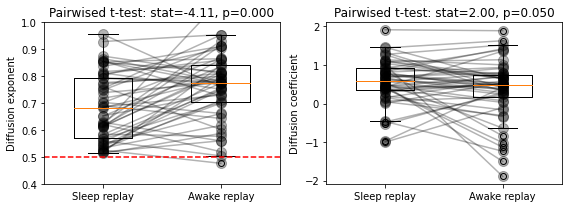

In [6]:
#barplot of SleepEXP and RunEXP in subplot 1, as well as SleepIntcp and RunIntcp in subplot 2
fig, ax = plt.subplots(1,2, figsize=(8,3))

ax[0].boxplot([SleepEXP, RunEXP], positions=[0,1], widths=0.5)
#add scatter plot
ax[0].scatter(np.zeros(len(SleepEXP)), SleepEXP, color='black', s=100, alpha=0.3)
ax[0].scatter(np.ones(len(RunEXP)), RunEXP, color='black', s=100, alpha=0.3)
#link paired data with a line
for i in range(len(SleepEXP)):
    ax[0].plot([0,1], [SleepEXP[i], RunEXP[i]], color='black', alpha=0.3)
    
#add a horizontal line at y=0.5 as red
ax[0].axhline(y=0.5, color='red', linestyle='--')
    
#carry out wilcoxon test
from scipy.stats import wilcoxon
#stat, p = wilcoxon(SleepEXP, RunEXP)
stat, p = ttest_rel(SleepEXP, RunEXP)

#add stats and p value to the title
#ax[0].set_title('Wilcoxon test: stat=%.2f, p=%.3f'%(stat, p))
ax[0].set_title('Pairwised t-test: stat=%.2f, p=%.3f'%(stat, p))
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['Sleep replay', 'Awake replay'])
ax[0].set_ylabel('Diffusion exponent')
ax[0].set_ylim([0.4,1.0])

#do the same for intercept
#add box plot not bar plot
ax[1].boxplot([SleepIntcp, RunIntcp], positions=[0,1], widths=0.5)
#add scatter plot
ax[1].scatter(np.zeros(len(SleepIntcp)), SleepIntcp, color='black', s=100, alpha=0.3)
ax[1].scatter(np.ones(len(RunIntcp)), RunIntcp, color='black', s=100, alpha=0.3)
#link paired data with a line
for i in range(len(SleepIntcp)):
    ax[1].plot([0,1], [SleepIntcp[i], RunIntcp[i]], color='black', alpha=0.3)

#carry out wilcoxon test
#stat, p = wilcoxon(SleepIntcp, RunIntcp)

#carry out paired t test
stat, p = ttest_rel(SleepIntcp, RunIntcp)

#add stats and p value to the title
ax[1].set_title('Pairwised t-test: stat=%.2f, p=%.3f'%(stat, p))
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['Sleep replay', 'Awake replay'])
ax[1].set_ylabel('Diffusion coefficient')

plt.tight_layout()

